# Tuto fonction fastmri

In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon')

In [2]:
import fastmri
from fastmri.data import transforms as T
import h5py
import torch
import numpy as np
from matplotlib import pyplot as plt

from utils_torch import virtual_coil_reconstruction, show_coils


## Import 

## Download data 

In [3]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
hf = h5py.File(file_path)
# print(hf)

## Manipulate data to understand and have the right format

Les données sont complex.  
Shape = [Batch , coils , H, W]

In [4]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)
# print(volume_kspace)

complex64
(16, 16, 640, 320)


Visualisation des données : kspace

In [5]:
slice_kspace = volume_kspace[volume_kspace.shape[1]-1] 
num_coils = slice_kspace.shape[0]

# for coil_index in range(num_coils):
#     show_coils(np.log(np.abs(slice_kspace) + 1e-9), [coil_index], cmap='gray')

In [6]:
volume_kspace= torch.tensor(volume_kspace, dtype=torch.complex64)

dimension = len(volume_kspace.shape) -2

if dimension == 2 :
    real_kspace = torch.fft.ifft2(volume_kspace)
else: 
    real_kspace = torch.fft.ifftn(volume_kspace)

real_kspace = torch.fft.fftshift(real_kspace)
print(real_kspace.shape)

torch.Size([16, 16, 640, 320])


In [7]:
slice_Rkspace = real_kspace[real_kspace.shape[1]-1] 
num_Rcoils = slice_Rkspace.shape[0]

# for coil_index in range(num_Rcoils):
#     show_coils(np.log(np.abs(slice_Rkspace) + 1e-9), [coil_index])

## Multicoil to Singlecoil

/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon/functions_torch/utils_torch.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs, dtype=torch.complex64)
/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon/functions_torch/utils_torch.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phase_reference = torch.tensor(


torch.Size([16, 640, 320])


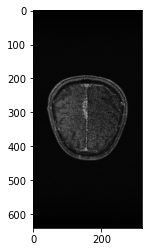

In [8]:
new_image_singlecoil = virtual_coil_reconstruction(real_kspace)
print(new_image_singlecoil.shape)

image_goodShape = new_image_singlecoil[0]
plt.imshow(np.abs(image_goodShape.numpy()), cmap='gray')

## Test for undersampling Mask 

### Re Manipulate the data to have the kspace 

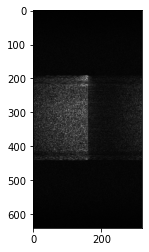

In [9]:
dimension = len(new_image_singlecoil.shape) - 1

if dimension == 2 :
    kspace_singlecoil = torch.fft.fft(new_image_singlecoil)
else : 
    kspace_singlecoil = torch.fft.fftn(new_image_singlecoil)


kspace_goodShape = kspace_singlecoil[0]
plt.imshow(np.abs(kspace_goodShape.numpy()), cmap='gray')

### Fastmri

Choose the sampling mask you want between the following.

random : genere a sampling mask randomly  
equispaced : genere a sampling mask with qually-spaced k-space lines  
equispaced_fraction : similar to equispaced with more precision about acceleration rate  
magic : genere a sampling mask who exploit conjugate symmetry  
magic_fraction : similar to magic with more precision about acceleration rate  

In [10]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_type_str = "random"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]

mask_func = create_mask_for_mask_type(mask_type_str, center_fractions, accelerations)

masked_func represent here the binary data of the mask.   
0 mean informatiosn in the data are note conserve.   
1 mean you take the information.   
    
accelerated_data is the fusion between the original data and sampling data.   
This is the data we gonna use.

In [11]:
## WITH THE KSPACE

masked_data , _ = mask_func(kspace_singlecoil.shape) 
accelerated_data_Kspace = kspace_singlecoil * masked_data
print(accelerated_data_Kspace.shape)

torch.Size([16, 640, 320])


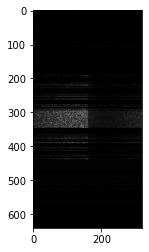

In [12]:
image_goodShape0 = accelerated_data_Kspace[0]
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')

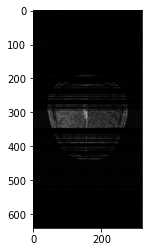

In [13]:
accelerated_data_Kspace = torch.fft.ifft(accelerated_data_Kspace)
image_goodShape0 = accelerated_data_Kspace[0]
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')

In [14]:
## WITH THE IMAGE

masked_data , _ = mask_func(new_image_singlecoil.shape) 
# print(masked_data)

accelerated_data = new_image_singlecoil * masked_data
print(accelerated_data.shape)

torch.Size([16, 640, 320])


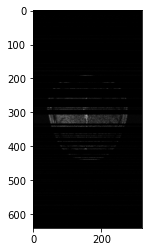

In [15]:
image_goodShape0 = accelerated_data[0]
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')

### Fasmri Reproductible Benchmark

In [16]:

# def gen_mask(kspace, accel_factor=8, seed=None):
#     # inspired by https://github.com/facebookresearch/fastMRI/blob/master/common/subsample.py
#     shape = kspace.shape
#     num_cols = shape[-1]
#     center_fraction = (32 // accel_factor) / 100
#     acceleration = accel_factor

#     # Create the mask
#     num_low_freqs = int(round(num_cols * center_fraction))
#     prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
#     mask = np.random.default_rng(seed).uniform(size=num_cols) < prob
#     pad = (num_cols - num_low_freqs + 1) // 2
#     mask[pad:pad + num_low_freqs] = True

#     # Reshape the mask
#     mask_shape = [1 for _ in shape]
#     mask_shape[-1] = num_cols
#     mask = mask.reshape(*mask_shape)
#     return mask

def gen_mask(kspace, accel_factor=8):
    shape = kspace.shape
    num_cols = shape[-1]

    center_fraction = (32 // accel_factor) / 100
    acceleration = accel_factor

    # Create the mask
    num_low_freqs = int(round(num_cols * center_fraction))
    prob = (num_cols / acceleration - num_low_freqs) / (num_cols - 3 * num_low_freqs)
    num_sampling = int(prob * num_cols)
    # selected_indexes = np.random.default_rng().randint(0, num_cols, size=(num_sampling, 2)).mean(axis=-1).astype('int')
    selected_indexes = np.random.default_rng().choice(num_cols, size=num_sampling, replace=False)
    mask = np.zeros((num_cols,)).astype('bool')
    mask[selected_indexes] = True
    pad = (num_cols - num_low_freqs + 1) // 2
    mask[pad:pad + num_low_freqs] = True

    # Reshape the mask
    mask_shape = [1 for _ in shape]
    mask_shape[-1] = num_cols
    mask = mask.reshape(*mask_shape)
    return mask

# import tensorflow as tf

# def gen_mask(kspace, accel_factor = 8, multicoil=False, fixed_masks=False):
#     shape = tf.shape(kspace)
#     num_cols = shape[-1] # initialement -1
#     center_fraction = (32 // accel_factor) / 100
#     num_low_freqs = tf.dtypes.cast(num_cols, 'float32') * center_fraction
#     num_low_freqs = tf.dtypes.cast((tf.round(num_low_freqs)), 'int32')
#     prob = (num_cols / accel_factor - tf.dtypes.cast(num_low_freqs, 'float64')) / tf.dtypes.cast((num_cols - num_low_freqs), 'float64')
#     if fixed_masks:
#         tf.random.set_seed(0)
#         seed = 0
#     else:
#         seed = None
#     mask = tf.random.uniform(shape=tf.expand_dims(num_cols, axis=0), dtype='float64', seed=seed) < prob
#     pad = (num_cols - num_low_freqs + 1) // 2
#     final_mask = tf.concat([
#         mask[:pad],
#         tf.ones([num_low_freqs], dtype=tf.bool),
#         mask[pad+num_low_freqs:],
#     ], axis=0)

#     # # Reshape the mask
#     mask_shape = tf.ones_like(shape)
#     if multicoil:
#         mask_shape = mask_shape[:3]
#     else:
#         mask_shape = mask_shape[:2]
#     final_mask_shape = tf.concat([
#         mask_shape,
#         tf.expand_dims(num_cols, axis=0),
#     ], axis=0)
#     final_mask_reshaped = tf.reshape(final_mask, final_mask_shape)
#     # we need the batch dimension for cases where we split the batch accross
#     # multiple GPUs
#     if multicoil:
#         final_mask_reshaped = tf.tile(final_mask_reshaped, [shape[0], 1, 1, 1])
#     else:
#         final_mask_reshaped = tf.tile(final_mask_reshaped, [shape[0], 1, 1])
#     fourier_mask = tf.cast(final_mask_reshaped, tf.uint8)
#     return fourier_mask


In [17]:
#  Representation binaire qui indique quel point sera conservé. 

masked_data1 = gen_mask(new_image_singlecoil)
# print(masked_data1)

accelerated_data1 = new_image_singlecoil * masked_data1
# print(accelerated_data)
print(accelerated_data1.shape)

torch.Size([16, 640, 320])


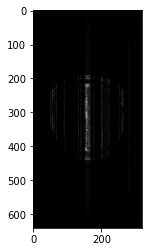

In [18]:
image_goodShape1 = accelerated_data1[0]
plt.imshow(np.abs(image_goodShape1.numpy()), cmap='gray')

## Result Sampling

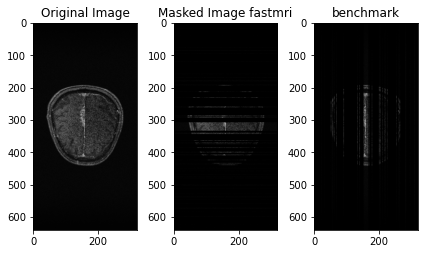

In [19]:

plt.subplot(1, 3, 1)
plt.imshow(np.abs(image_goodShape.numpy()), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')
plt.title('Masked Image fastmri')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(image_goodShape1.numpy()), cmap='gray')
plt.title('benchmark')

plt.tight_layout()
plt.show()


## Modele Reseaux Neurones

Le soucis avec Unet() = > Nombre complex. 

In [46]:
from fastmri.data import transforms
from fastmri.data.subsample import RandomMaskFunc
from fastmri.models import Unet, VarNet

In [47]:
def create_input(shape):
    x_real = np.arange(np.prod(shape)).reshape(shape)
    x_imag = np.arange(np.prod(shape)).reshape(shape) * 2  
    x_complex = x_real + 1j * x_imag  
    x = torch.tensor(x_complex, dtype=torch.complex64)

    return x

In [50]:
shape  = [16, 1, 640, 320]
center_fractions = [0.08]
accelerations = [4]

mask_func = RandomMaskFunc(center_fractions, accelerations)
x = create_input(shape)
outputs, masks = [], []
for i in range(x.shape[0]):
    output, mask, _ = transforms.apply_mask(x[i : i + 1], mask_func, seed=123)
    outputs.append(output)
    masks.append(mask)

output = torch.cat(outputs)
mask = torch.cat(masks)

varnet = VarNet(
    num_cascades=2,
    sens_chans=4,
    sens_pools=2,
    chans=1,
    pools=2,
    mask_center=True,
)

y = varnet(output, mask.byte())

IndexError: too many indices for tensor of dimension 4

In [44]:
shape  = [16, 1, 640, 320]

xR = create_input(shape)
# print(xR.shape)
# print(xR.dtype)
# xR = x.abs() ## remet en nombre reel (pas la solution)

num_chans = xR.shape[1]
unet = Unet(in_chans=num_chans, out_chans=1, chans=1, num_pool_layers=2)
y = unet(xR)

# print(y)
ya = y[0, 0, :, :]
print(ya.shape)
print(ya)
plt.imshow(np.abs(ya.detach().numpy()), cmap='gray')


RuntimeError: Input type (CPUComplexFloatType) and weight type (torch.FloatTensor) should be the same

suite test

In [31]:
accelerated_data_unet = accelerated_data.unsqueeze(1)
# Vous avez maintenant une forme (N, in_chans, H, W)
print(accelerated_data_unet.shape)

torch.Size([16, 1, 640, 320])


In [ ]:
# accelerated_data_unet_R = accelerated_data_unet.abs()
# print(accelerated_data_unet_R)

In [35]:
model = Unet(in_chans=accelerated_data_unet.shape[1], out_chans=5, chans=1 , num_pool_layers=2)

output_tensor = model(accelerated_data_unet)

RuntimeError: Input type (CPUComplexFloatType) and weight type (torch.FloatTensor) should be the same

torch.Size([640, 320])


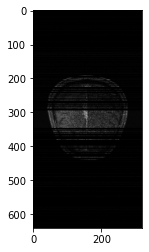

In [ ]:
youpi = accelerated_data_unet[0, 0, :, :]
print(youpi.shape)
plt.imshow(np.abs(youpi.detach().numpy()), cmap='gray')